In [ ]:
# from google.colab import files

# # Upload zip file
# uploaded = files.upload()

In [ ]:
# import zipfile
# import io

# # Get the first (and only) key in the dictionary
# zip_file_name = list(uploaded.keys())[0]

# with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
#     zip_ref.extractall('/content/')

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
# Updated TPU detection and initialization
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Device:', tpu.master())
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)  # Updated to non-experimental TPUStrategy
except ValueError:
  strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.119.216.162:8470
Number of replicas: 8


In [ ]:
train_data = pd.read_csv('/content/171_project/data/training.csv')

for column in train_data.columns:
    train_data[column].fillna(train_data[column].median(), inplace=True)

In [ ]:
def sort_pattern(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_images(path):
    images = []
    file_list = os.listdir(path)
    sorted_file_list = sorted(file_list, key=sort_pattern)

    for filename in sorted_file_list:
        if filename.endswith(".jpg"):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert('L')
            img = img.resize((227, 227))  # Resize for AlexNet
            images.append(np.array(img))  # Convert PIL Image to NumPy array
            img.close()

    return images

def show_keypoints(images, keypoints, n_rows=3, n_cols=7, original_size=96, new_size=227):
    scaling_factor = new_size / original_size
    scaled_keypoints = keypoints * scaling_factor

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), dpi=100)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            break  # If there are fewer images than subplots, exit the loop early

        img_array = images[i]
        if img_array.shape[0] != new_size or img_array.shape[1] != new_size:
            raise ValueError(f"Image size expected to be {new_size}x{new_size}, but was {img_array.shape[0]}x{img_array.shape[1]}")

        ax.imshow(img_array, cmap='gray')
        ax.axis('off')  # Hide the axis
        ax.set_title(f'Sample #{i}')

        # Keypoints are expected to be in (x, y) pairs
        for j in range(0, len(keypoints[i]), 2):
            x = scaled_keypoints[i][j]
            y = scaled_keypoints[i][j + 1]
            ax.plot(x, y, 'ro', markersize=2)

    plt.tight_layout()
    plt.show()

In [ ]:
path = r"/content/171_project/data/images/train_images"
images = load_images(path)

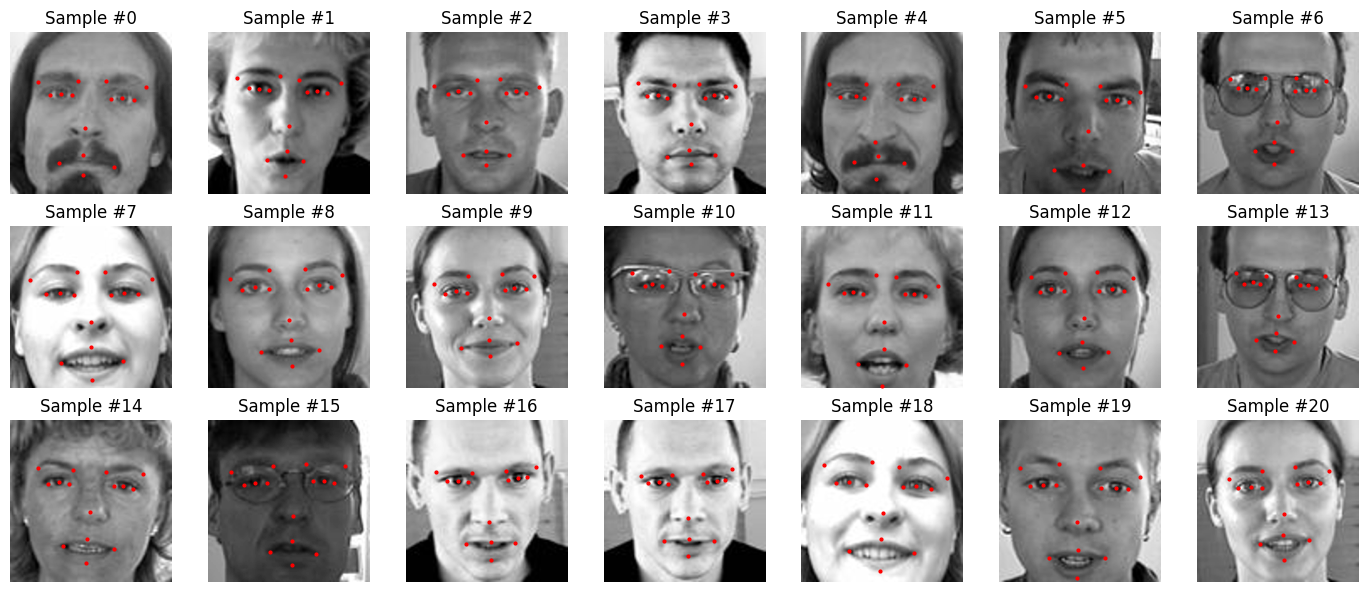

In [ ]:
show_keypoints(images[:21], train_data.values[:21])

In [ ]:
x_train = np.array(images).reshape(-1, 227, 227, 1).astype('float64')
y_train = train_data.values.astype('float64')

In [ ]:
# Split the data into training and validation sets (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=21)

# Make sure the data is in the correct shape and type
x_train = x_train.reshape(-1, 227, 227, 1).astype('float64')
x_val = x_val.reshape(-1, 227, 227, 1).astype('float64')

In [ ]:
with strategy.scope():
    def AlexNet(input_shape=(227, 227, 1), num_outputs=30):
        model = Sequential([
            # 1st Convolutional Layer
            Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # 2nd Convolutional Layer
            Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # 3rd Convolutional Layer
            Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),

            # 4th Convolutional Layer
            Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),

            # 5th Convolutional Layer
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # Passing it to a Fully Connected layer
            Flatten(),

            # 1st Fully Connected Layer
            Dense(4096, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),

            # 2nd Fully Connected Layer
            Dense(4096, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),

            # Output Layer for Regression
            Dense(num_outputs)  # No activation function (linear)
        ])
        return model

    alexnet_model = AlexNet(input_shape=(227, 227, 1), num_outputs=30)
    alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

reduce_LR = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              verbose=1,
                              mode='min',
                              min_lr=1e-9)

alexnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='mean_squared_error', metrics=['mae'])

In [ ]:
batch_size = 24 * strategy.num_replicas_in_sync
terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

history = alexnet_model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_LR, terminate_on_nan]
)

Epoch 1/100
30/30 [==============================] - 16s 284ms/step - loss: 964.9726 - mae: 23.8493 - val_loss: 36141716.0000 - val_mae: 5001.2119 - lr: 0.0100
Epoch 2/100
30/30 [==============================] - 4s 119ms/step - loss: 60.6379 - mae: 6.1101 - val_loss: 1295.7225 - val_mae: 30.4649 - lr: 0.0100
Epoch 3/100
30/30 [==============================] - 4s 152ms/step - loss: 28.7597 - mae: 3.9077 - val_loss: 54.4055 - val_mae: 3.4861 - lr: 0.0100
Epoch 4/100
30/30 [==============================] - 5s 163ms/step - loss: 23.6820 - mae: 3.4865 - val_loss: 16.9659 - val_mae: 2.7552 - lr: 0.0100
Epoch 5/100
30/30 [==============================] - 3s 113ms/step - loss: 20.4345 - mae: 3.2143 - val_loss: 13.7181 - val_mae: 2.5319 - lr: 0.0100
Epoch 6/100
30/30 [==============================] - 3s 101ms/step - loss: 18.4757 - mae: 3.0253 - val_loss: 14.5067 - val_mae: 2.7959 - lr: 0.0100
Epoch 7/100
30/30 [==============================] - 3s 115ms/step - loss: 17.3708 - mae: 2.8997 

In [ ]:
# Save the trained model to a file
alexnet_model.save('alexnet_model2.h5')
# Download the saved model file
files.download('alexnet_model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

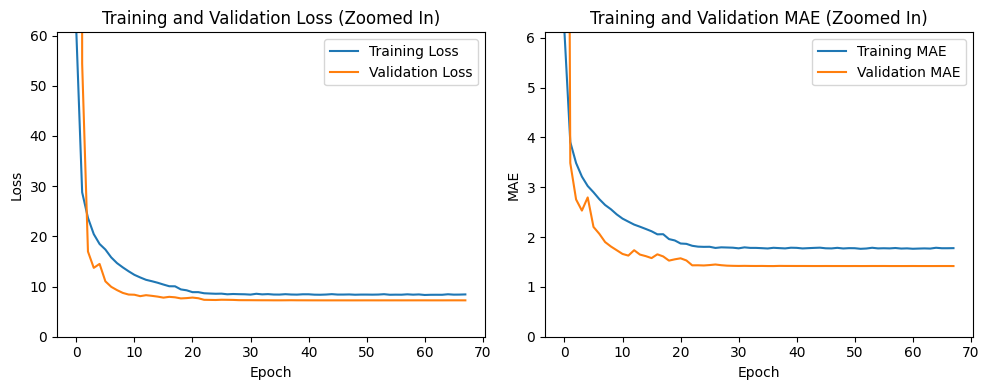

In [24]:
start_index = 1

max_training_loss_zoomed = max(history.history['loss'][start_index:])
max_training_mae_zoomed = max(history.history['mae'][start_index:])

#### 1. Training Loss and Validation Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][start_index:], label='Training Loss')
plt.plot(history.history['val_loss'][start_index:], label='Validation Loss')
plt.title('Training and Validation Loss (Zoomed In)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max_training_loss_zoomed)
plt.legend()

#### 2. Training MAE and Validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'][start_index:], label='Training MAE')
plt.plot(history.history['val_mae'][start_index:], label='Validation MAE')
plt.title('Training and Validation MAE (Zoomed In)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim(0, max_training_mae_zoomed)
plt.legend()

plt.tight_layout()
plt.show()

56/56 [==============================] - 2s 17ms/step


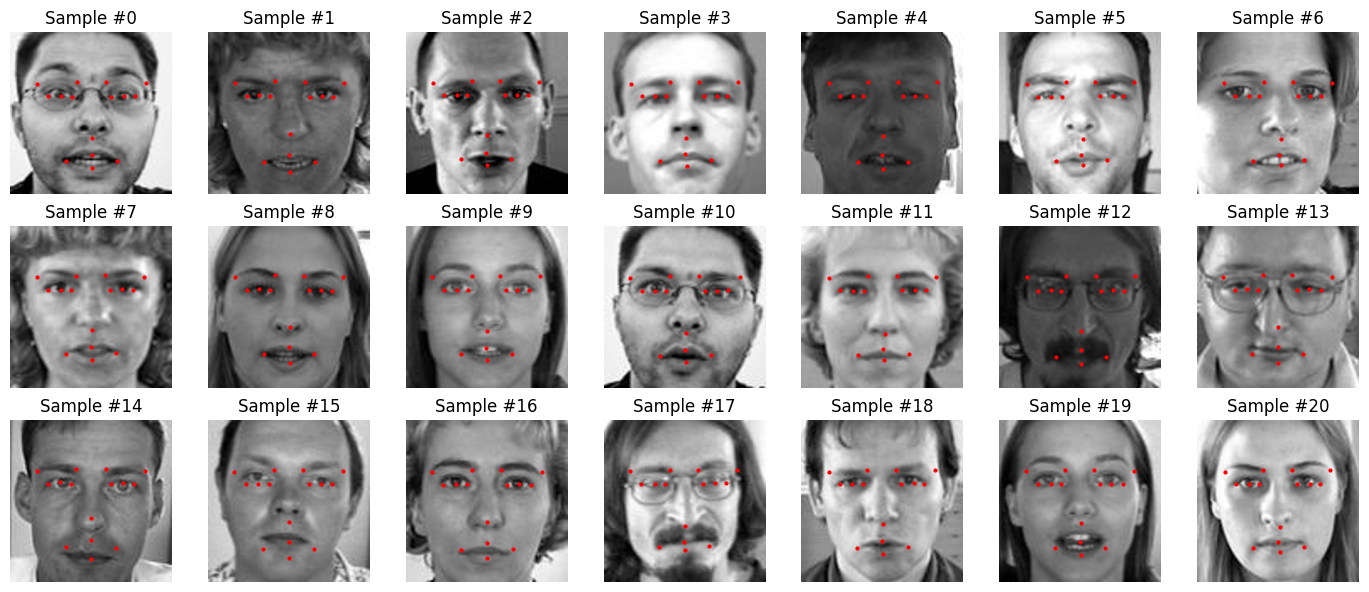

In [ ]:
test_path = "/content/171_project/data/images/test_images"
test_images = load_images(test_path)

test_images_array = np.array(test_images).reshape(-1, 227, 227, 1).astype('float64')

# Predict keypoints using the model
predicted_keypoints = alexnet_model.predict(test_images_array)

show_keypoints(test_images[:21], predicted_keypoints[:21])
